<a href="https://colab.research.google.com/github/kinimoDR/Matematikai-Programcsomagok/blob/main/Food_classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Képek feltöltése (a food-14 adathalmazt használjuk)

In [ ]:
!pip install -q gdown
!gdown --id 1dYtKeLefedj71KhCCdYI-qjwY60qYzA3 -O food-14.zip
!unzip -q food-14.zip -d food-14

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1dYtKeLefedj71KhCCdYI-qjwY60qYzA3
From (redirected): https://drive.google.com/uc?id=1dYtKeLefedj71KhCCdYI-qjwY60qYzA3&confirm=t&uuid=d8c52e55-5c39-44f4-9fa7-d73a7d798412
To: /content/food-14.zip
100% 710M/710M [00:11<00:00, 59.6MB/s]


## 2. Adathalmzok létrehozása

In [ ]:
#Pytorch alapú képbetöltés

# importálás
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image

# példakép - annak ellenőrzése, hogy sikerült-e megfelelően letölteni az adathalmazt
img = Image.open('food-14/Projekt/pizza/1001116.jpg')
print(f"{img.size[0]} x {img.size[1]}")  #példakép méreteinek kiíratása (szélesség x magasság)

# képresizeoló és tenzorrá alakító függvények
train_transform = transforms.Compose([
    transforms.Resize((224, 224)), #Minden képet 224 x 224-es méretű képpé alakít, hogy a modellnek ne kelljen a méretekkel külön foglalkoznia
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(15),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    #transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(), #pytorch tenzorrá alakítás (nagyon hasonló a numpy arrayhez)
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) #lenormálás - mindhárom RGB chanel elemeit 0.5 átlaggal és 0.5 szórással normáljuk: x -> (x-0.5)/0.5
])
valtest_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# adathalmaz betöltése
dataset = datasets.ImageFolder('/content/food-14/Projekt')


# kategóriák
class_names = dataset.classes
print(f"Kategóriák: {class_names}")

# Train/Test/Val split (80/10/10)
total_size = len(dataset)
val_size = total_size // 10
test_size = total_size // 10
train_size = total_size - val_size - test_size

train_data, val_data, test_data = random_split( #random felosztja a teljes adathalmazt a megadott méretű részekre
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42) #pszeudorandom szám generátor - seed használata miatt minden esetben ugyanazok lesznek a halmazok, a generálás ugyanazt hajtja végre
)

#a feljebb definiált transzrormációk végrehajtása a 3 adathalmazon
train_data.dataset.transform = train_transform
val_data.dataset.transform = valtest_transform
test_data.dataset.transform = valtest_transform


#batch méretek - batch: adatok (most képek) csoportja, amit a modell együtt fog kezelni
train_batch_size = 64
valtest_batch_size = 128

#dataloaderek - mindhárom adathalmazhoz egy iterálható objektum, amely a megadott batch méretekre fel is osztja az adathalmazt
train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_data, batch_size=valtest_batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_data, batch_size=valtest_batch_size, shuffle=False, num_workers=2)

512 x 512
Kategóriák: ['apple_pie', 'donuts', 'french_fries', 'hamburger', 'hot_dog', 'ice_cream', 'lasagna', 'pad_thai', 'pizza', 'spaghetti_bolognese', 'steak', 'sushi', 'tiramisu', 'waffles']


## 3. GPU teszt

In [ ]:
#Annak tesztelése, hogy a google colab rá tudott-e csatlakozni a GPU-ra, mert azon szeretnénk majd futtatni a kódunkat, hogy effektívebb és gyorsabb legyen
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0))


CUDA available: True
GPU name: Tesla T4


## 4. Konvolúciós neurális háló (CNN) és early stopping definiálása

In [ ]:
import torch.nn as nn
import torch.optim as optim

class CNN(nn.Module): #az nn.Module standard modellosztálynak egy "alosztályát" hozzuk létre, hogy a később használt beépített függvények működjenek rá
    def __init__(self): #a rétegeket itt definiáljuk
        super(CNN, self).__init__() #ez a sor biztosítja, hogy "megörökölje" az osztályunk az nn.Module osztály függvényeit, metódusait
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), #konvolúciós réteg: 3 input csatorna -> 64 output csatorna, a konvolúciót egy 3 x 3-as kernellel végezzük, a padding pedig egy csupa 0 "keretet" hoz létre, hogy a kép mérete ne változzon
            nn.BatchNorm2d(64), #normalizáció: minden input channel esetén kiszámolja, egy batch áltagát és szórását és a már korábban látott módon lenormál minden inputot (haszna: a gradiensek ne tűnjenek/szálljanak el)
            nn.ReLU(), #aktivációs függvény: x -> max(0,x)
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 224 → 112 (2x2-es négyzetekre osztja a képet és minden channel értékeinek veszi a 2x2-es négyzetben a maximumát, így minden 2x2-es négyzetet 1 db pixellel fog helyettesíteni, ezért csökken a méret)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 112 → 56

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 56 → 28

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 28 → 14

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 14 → 7
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), #minden channelen kiátlagolja az értékeket és 1 db értékkel helyettesíti - jóval csökken a méret
            nn.Flatten(), #kép "kilapítása" egy vektorrá
            nn.Linear(512, 512), #lineáris réteg (lineáris leképezést hajt végre)
            nn.ReLU(), #aktivációs függvény
            nn.Linear(512, 14) #végső lineáris réteg: az output mérete már az osztályok száma
        )

    def forward(self, x): #az input végigmegy az összes rétegen sorban
        x = self.features(x)
        x = self.classifier(x)
        return x

# Early stopping: ezen tecnika megelőzi a modellünk túltanulását

class Early_stopping():
  def __init__(self,start_acc,max_epoch,path,model=CNN):
    # a példány tulajdonságai
    self.best_acc=start_acc # start_acc: kezdési pontossági küszöb
    self.max_epoch=max_epoch  # max_epoch: legfeljebb ennyiszer megyünk végig az egész adathalmazon az utolsó javulást követően
    self.epoch=0 # számontartjuk hányadik epochnál járunk, amelynél nem javult a modell pontossága
    self.path=path # path: a legjobb model mentési helye
    self.model=model # milyen modellt használunk (default: CNN)

  def step(self,current_acc):
    self.epoch+=1 # lépünk
    if current_acc > self.best_acc: #javult a pontosság
      self.best_acc=current_acc # frissítjük a pontosságot
      self.epoch=0 # az előbbiek miatt lenullázzuk az epoch-számlálót
      torch.save(self.model,self.path) # frissítjük a mentett modellt
      return False # úgy írjuk meg a tanítást, hogy folytatjuk az ES false outputot egy epoch után

    elif self.epoch > self.max_epoch: # elég régóta nem javult a model pontossága
      return True # leállunk

    else: # ha nem javul vagy nem romlik eleget
      return False # folytatjuk

##5. Futtatókörnyezet (ideális esetben GPU)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 6. Drive fájlok elérhetőségének biztosítása (modell mentéséhez, betöltéséhez)

In [ ]:
#a modell drivra mentéséhez és driveról betöltéséhez szükséges
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## 7. Random CNN létrehozása: ha előről szeretnénk tanítani a modellt

In [ ]:
cnn = CNN()  #itt az osztály egy random elemét hozzuk létre: ezt lehet később tanítani a feladatra
print("Modell mérete:", sum(p.numel() for p in cnn.parameters()) / 1e6, "millió paraméter") #modell mérete

#csak akkor tegyük át gpu-ra, ha nem crashel ki
try:
    cnn.to(device)
    cnn.cuda() #ivan
    print("Modell áthelyezve", device)
except RuntimeError as e:
    print("Áthelyezés sikertelen", e)

Modell mérete: 9.680718 millió paraméter
Modell áthelyezve cuda


## 8. Mentett modell betöltése

### Példa

In [ ]:
cnn = torch.load('/gdrive/MyDrive/cnn.pt', weights_only = False, map_location = device) #1. paraméter a mentett modell elérési útja legyen

### Saját

In [ ]:
#Martin
cnn = torch.load('/gdrive/MyDrive/cnn.pt másolata', weights_only = False)

In [ ]:
#Dominik
cnn = torch.load('/gdrive/MyDrive/cnn.pt', weights_only = False, map_location = device)

In [ ]:
#Marci
cnn = torch.load('/gdrive/MyDrive/cnn.pt', weights_only = False, map_location = device)

## 9. Optimalizáló algoritmus és learning rate scheduler

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR
criterion=nn.CrossEntropyLoss() #klasszifikációs feladatoknál ajánlott loss függvény
optimizer=optim.AdamW(cnn.parameters(),lr=0.0001) #optimalizáló algoritmus - hatékony adaptív gradiens ereszkedés


scheduler = ExponentialLR(optimizer, gamma=0.95) #learning rate sheduler - amikor léptetjük 1-gyel, akkor a learning ratet gamma-szorosára változtatja


es=Early_stopping(0, 10, "cnn.pt", cnn) #a modellhez tartozó early stopping definiálása
print("Model is on:", next(cnn.parameters()).device)

Model is on: cuda:0


## 10. Tanítás

In [ ]:
num_epochs = 30 #tervezett epochok száma
train_losses = [] #loss értékek tárolása
train_accuracies = []
val_losses = []
val_accuracies = []
test_accuracies = []
epochs = [] #epoch indexek tárolása

for epoch in range(num_epochs):
    epochs.append(epoch)
    #tanító fázis
    cnn.train() #a modellt tanító módra állítjuk - ez hatással van néhány rétegre, pl. dropout (mi ezt nem használtuk), batchnorm (tanító módban az aktuális batch adatai alapján normál)
    total_train_loss = 0.0
    train_correct, train_total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) #áttesszük GPU-ra az adatokat
        optimizer.zero_grad() #az előző epoch gradienseit töröljük

        outputs = cnn(images) #modell predikciója, jóslata
        loss = criterion(outputs, labels) #kiszámoljuk a loss értéket a helyes címkék és a predikciók között

        loss.backward() #backpropagation
        optimizer.step() #az optimalizáló algoritmus hajtson végre egy lépést

        total_train_loss += loss.item() #az egész tanító halmazon vett losst számoljuk, ehhez adjuk hozzá az adott batch loss értékét
        pred = outputs.argmax(dim=1) #a "legvalószínűbb"-nek jósolt osztály legyen a predikció
        train_correct += (pred == labels).sum().item() #helyes jóslatok számát növeljük az adott batch helyes jóslatainak számával
        train_total += labels.size(0) #az összes jóslat számát növeljük a batch méretével

        #Memória felszabadítása
        del images, labels, outputs, loss
        torch.cuda.empty_cache() #nem használt memória törlése

    avg_train_loss = total_train_loss / len(train_loader) #átlagos loss
    train_accuracy = train_correct/train_total #pontosság a tanító halmazon
    train_losses.append(avg_train_loss) #a train_losses listában az átlagos loss értékeket tartjuk fenn minden epochra
    train_accuracies.append(train_accuracy)

    cnn.eval() #a validációhoz és teszthez kiértékelő módba állítjuk a modellt

    # validációs fázis
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad(): #kiértékelünk, így nem kell gradiens
        for images, labels in val_loader: #a tanító halmazhoz hasonlóan végrehajtjuk a számításokat, csak most nem számolunk gradienseket, nem végzünk backpropagationt
            images, labels = images.to(device), labels.to(device)
            outputs = cnn(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    scheduler.step() #léptessük a learning rate módosítót 1-gyel
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # teszt fázis
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:  #hasonlóan a validációhoz
            images, labels = images.to(device), labels.to(device)
            outputs = cnn(images)
            predicted = outputs.argmax(dim=1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

    test_accuracy = test_correct / test_total
    test_accuracies.append(test_accuracy)

    #epoch eredményeinek kiíratása
    print(f"Epoch {epoch+1}: "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Train accuracy: {train_accuracy:.2%},"
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Acc: {val_accuracy:.2%}, "
          f"Test Acc: {test_accuracy:.2%}")

    #Early stopping
    early_stop = es.step(val_accuracy) #a pontosságra fókuszálunk, így az alapján léptetjük az early_stoppingot
    if early_stop: #ha már jó (a paraméterekkel megadott) ideje nem javult a modell, álljunk le
        print("Early stopping triggered.")
        break

    #Memóriafelszabadítás
    torch.cuda.empty_cache()

Epoch 1: Train Loss: 2.2280, Train accuracy: 27.13%,Val Loss: 2.3208, Val Acc: 24.86%, Test Acc: 24.43%
Epoch 2: Train Loss: 1.8576, Train accuracy: 39.32%,Val Loss: 2.2696, Val Acc: 31.57%, Test Acc: 32.14%
Epoch 3: Train Loss: 1.6083, Train accuracy: 48.27%,Val Loss: 1.8446, Val Acc: 39.50%, Test Acc: 41.86%
Epoch 4: Train Loss: 1.3867, Train accuracy: 55.50%,Val Loss: 1.9658, Val Acc: 40.14%, Test Acc: 41.00%
Epoch 5: Train Loss: 1.2230, Train accuracy: 60.85%,Val Loss: 2.1152, Val Acc: 44.57%, Test Acc: 46.07%
Epoch 6: Train Loss: 1.1018, Train accuracy: 65.10%,Val Loss: 1.5017, Val Acc: 52.07%, Test Acc: 53.79%


## 11. Kiértékelő epoch

In [ ]:
#a tanító halmazon is csak kiértékelünk - lementett modell teljesítményének ellenőrzésére

cnn.eval()
total_train_loss = 0.0
train_correct, train_total = 0, 0

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = cnn(images)
        loss = criterion(outputs, labels)

        total_train_loss += loss.item()
        pred = outputs.argmax(dim=1)
        train_correct += (pred == labels).sum().item()
        train_total += labels.size(0)

        #Memória felszabadítása
        del images, labels, outputs, loss
        torch.cuda.empty_cache()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = train_correct/train_total

# validációs fázis
val_loss, val_correct, val_total = 0.0, 0, 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        predicted = outputs.argmax(dim=1)
        val_correct += (predicted == labels).sum().item()
        val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total

# teszt fázis
test_correct, test_total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn(images)
        predicted = outputs.argmax(dim=1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = test_correct / test_total

print(f"Train Loss: {avg_train_loss:.4f}, "
      f"Train accuracy: {train_accuracy:.2%},"
      f"Val Loss: {avg_val_loss:.4f}, "
      f"Val Acc: {val_accuracy:.2%}, "
      f"Test Acc: {test_accuracy:.2%}")

Train Loss: 0.0018, Train accuracy: 100.00%,Val Loss: 1.0820, Val Acc: 73.93%, Test Acc: 76.71%


## 12. Statisztikák

In [ ]:
# Eltároljuk a modell predikcióit statisztikai felhasználás céljából

num_epochs = 30
def pred(model, dataloader, device):
    model.eval()
    y_preds=[]
    y_trues=[]
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            pred=model(images)
            preds=torch.argmax(pred, dim=1)
            y_preds.append(preds)
            y_trues.append(labels)
    return torch.cat(y_preds),torch.cat(y_trues)

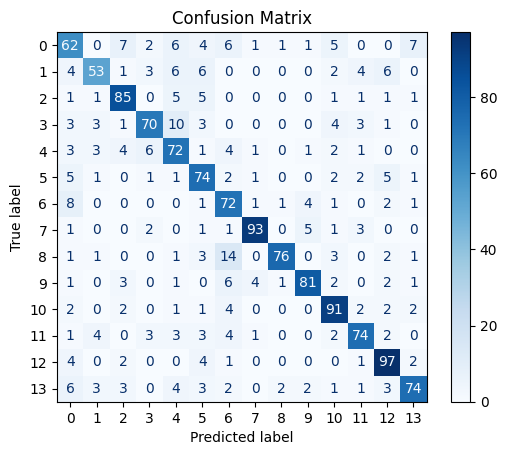

In [ ]:
# Confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred,y_true=pred(cnn,test_loader,device)
# y_true: valódi címkék
# y_pred: a modell által prediktált címkék
# Ezeket torch tensorból numpy tömbbé konvertáljuk

y_true = y_true.cpu().numpy()
y_pred = y_pred.cpu().numpy()

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")  # választható colormap
plt.title("Confusion Matrix")
plt.show()

NameError: name 'train_losses' is not defined

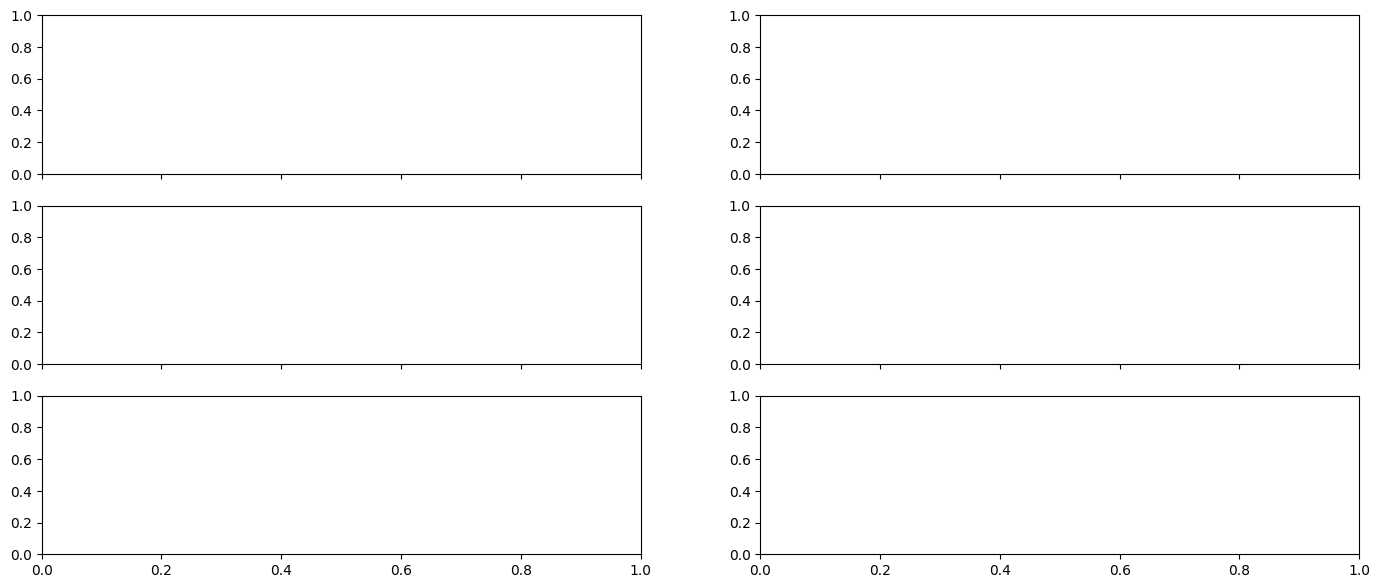

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(17, 7), sharex=True)

# train loss
axs[0][0].plot(num_epochs, train_losses, label='Train Loss', color='blue')
axs[0][0].set_ylabel('Loss')
axs[0][0].set_title('Training Loss')
axs[0][0].grid(True)

# train accuracy
axs[0][1].plot(num_epochs, train_accuracies, label='Train Accuracy', color='blue')
axs[0][1].set_ylabel('Accuracy')
axs[0][1].set_title('Training Accuracy')
axs[0][1].grid(True)

# validation loss
axs[1][0].plot(num_epochs, val_losses, label='Validation Loss', color='orange')
axs[1][0].set_ylabel('Loss')
axs[1][0].set_title('Validation Loss')
axs[1][0].grid(True)

# validation accuracy
axs[1][1].plot(num_epochs, val_accuracies, label='Validation Accuracy', color='orange')
axs[1][1].set_ylabel('Accuracy')
axs[1][1].set_title('Validation Accuracy')
axs[1][1].grid(True)

# test accuracy
axs[2][1].plot(num_epochs, test_accuracies, label='Test Accuracy', color='green')
axs[2][1].set_xlabel('Epochs')
axs[2][1].set_ylabel('Accuracy')
axs[2][1].set_title('Test Accuracy')
axs[2][1].grid(True)

plt.tight_layout()
plt.show()

## 13. Modell mentése drivera

In [ ]:
import shutil
shutil.copy("cnn.pt", "/gdrive/MyDrive/cnn.pt") #a második paraméterbe a mentési helyet kell beírni

## 14. Jóslatok és valódi címkék összehasonlítása néhány példaképen a teszthalmazból

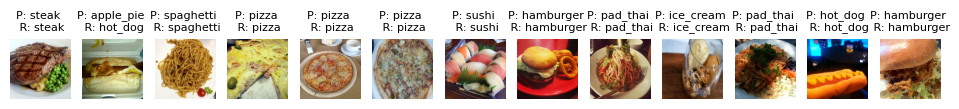

In [ ]:
from matplotlib import pyplot as plt
def unnormalize(img_tensor): #normalizált képek visszatranszformálása az eredeti állapotukba
    mean = torch.tensor([0.5, 0.5, 0.5])
    std = torch.tensor([0.5, 0.5, 0.5])
    img_tensor = img_tensor * std[:, None, None] + mean[:, None, None]
    return img_tensor

k = 13
#a teszthalmazból kivesszük az első k képet és kiszámoljuk rá a modell által prediktált értékeket
examples = iter(test_loader)
images, labels = next(examples)
images, labels = images[:k], labels[:k]
outputs = cnn(images.to(device))
preds = torch.argmax(outputs, dim=1)

#plot létrehozása
plt.figure(figsize=(12, 2))
for i in range(k):
    img = unnormalize(images[i].cpu())  #a visszatranszformált képeket a plotoláshoz visszarakjuk cpu-ra
    img = img.permute(1, 2, 0).numpy()  #a képek paramétereinek sorrendjét módosítjuk: [Channels, Height, Width] → [H, W, C], valamint a tenzorokat numpy tömbbé alakítjuk a plotoláshoz

    plt.subplot(1, k, i + 1) #létrehozzuk az adott kép plotját
    plt.imshow(img) #kép megjelenítése
    plt.axis('off') #ne jelenek megjelenítve a tengelyek
    plt.title(f"P: {class_names[preds[i].item()][:9]} \n R: {class_names[labels[i].item()][:9]}", fontsize = 8) #a címben: P:predikció, R:valódi címke
plt.show()

Interface készítése

In [ ]:
!pip install --quiet torch torchvision gradio pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import gdown, os

FILE_URL = "https://drive.google.com/uc?export=download&id=1malP-ZpMKR1oZL-DNTz1dRW03PAn8nD5"
PT_PATH  = "food14_cnn.pt"

if not os.path.exists(PT_PATH):
    gdown.download(FILE_URL, PT_PATH, quiet=False)

In [ ]:
import torch, torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class FoodCNN(nn.Module):
    def __init__(self, num_classes: int = 14):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch.serialization as ts
ts.add_safe_globals({'CNN': FoodCNN})
globals()['CNN'] = FoodCNN

ckpt = torch.load(PT_PATH, map_location=device, weights_only=False)

if isinstance(ckpt, dict) and not isinstance(ckpt, nn.Module):
    model = FoodCNN().to(device)
    # handle plain state‑dicts and Lightning‑style checkpoints
    state = ckpt.get("state_dict", ckpt.get("model_state_dict", ckpt))
    state = {k.split(".", 1)[-1]: v for k, v in state.items()}
    model.load_state_dict(state)
else:
    model = ckpt.to(device)

model.eval()


FoodCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding

In [ ]:
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)   # [-1,+1]
])

idx_to_class = ['apple_pie', 'donuts', 'french_fries',
                'hamburger', 'hot_dog', 'ice_cream', 'lasagna',
                'pad_thai', 'pizza', 'spaghetti_bolognese', 'steak',
                'sushi', 'tiramisu', 'waffles']

In [ ]:
#!pip install gradio
import gradio as gr, torch.nn.functional as F
from PIL import Image

@torch.no_grad()
def infer(img: Image.Image):
    x = transform(img).unsqueeze(0).to(device)
    prob = F.softmax(model(x), dim=1)[0]
    return {idx_to_class[i]: float(prob[i]) for i in range(len(idx_to_class))}

demo = gr.Interface(
    fn=infer,
    inputs=gr.Image(type='pil', label='Tölts fel képet'),
    outputs=gr.Label(num_top_classes=3, label='Top‑3 kategória'),
    title='FOOD‑14 Classifier',
    description='Drag‑and‑drop'
)
demo.launch(inline=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bb15d7af231c5fb827.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Új szakasz